# Identifying Best EMAs and Suggesting Trades

In [300]:
import os
from IPython.display import Image
Image("Pic3.png",width=900, height=700)

# Trading Strategy:
1.	Identify BTC’s trend (Positive or Negative Positions)
2.	Identify BTC’s best performing EMA
3.	Identify the best COIN to trade in relation to BTC (Correlation/Sensitivity)
4.	Apply the best performing EMA to the target COIN
5.	Suggest trades on the target COIN


## Agenda:
1. Loading the Data
2. Running Regression
3. Plotting Regression
4. Calculating Velocity
5. Calculating Bounce Rate Efficiency
6. Finding the best EMA
7. Calculating the Correlations between BTC and Other Coins
8. Suggesting Trades
9. Plotting Suggested Trades
10. Backtesting
11. Streamlit App

## 1. Loading the data

In [59]:
import streamlit as st
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime, timedelta
from binance.client import Client
from sklearn.linear_model import LinearRegression
from PIL import Image

# Set your Binance API credentials
# API_KEY = ''
# API_SECRET = ''

# Initialize Binance client
client = Client(API_KEY, API_SECRET, {"timeout": 2})

def fetch_crypto_data(symbol, interval, days=3):
    """Fetch historical data for a given symbol and interval."""
    since = int((datetime.now() - timedelta(days=days)).timestamp() * 1000)
    candles = client.get_klines(symbol=symbol, interval=interval, startTime=since)
    df = pd.DataFrame(candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df


In [61]:
btc_df = fetch_crypto_data('BTCUSDT', "15m", days = 2)
btc_df

timestamp      open      high       low     close      volume
0   2025-01-09 12:45:00  93347.07  93443.39  93155.25  93421.94   198.19604
1   2025-01-09 13:00:00  93421.94  93486.19  93085.15  93085.15   214.71849
2   2025-01-09 13:15:00  93085.15  93238.87  92684.02  92872.01   606.49880
3   2025-01-09 13:30:00  92872.02  92918.83  92100.00  92334.27  1428.16743
4   2025-01-09 13:45:00  92334.27  92405.69  91900.12  91986.42  1225.05088
..                  ...       ...       ...       ...       ...         ...
187 2025-01-11 11:30:00  94597.03  94791.67  94580.51  94751.99    86.47182
188 2025-01-11 11:45:00  94752.00  94752.01  94600.00  94625.65    61.80892
189 2025-01-11 12:00:00  94625.66  94649.70  94528.01  94540.35    57.53704
190 2025-01-11 12:15:00  94540.36  94655.20  94540.35  94601.26    44.13630
191 2025-01-11 12:30:00  94601.26  94601.27  94601.26  94601.27     0.00290

[192 rows x 6 columns]

## 2. Running Regression

In [7]:
def calculate_regression(df):
    """Calculate regression analysis to determine trend."""
    X = np.arange(len(df)).reshape(-1, 1)
    y = df['close'].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    slope = model.coef_[0]
    return 'Positive' if slope > 0 else 'Negative' if slope < 0 else 'Flat', y_pred

In [65]:
btc_trend, y_pred = calculate_regression(btc_df)
btc_trend

'Positive'

## 3. Plotting Regression

In [69]:
def plot_regression(df, y_pred, height=500):
    """Plot regression analysis."""
    plt.figure(figsize=(12, height / 100))
    plt.plot(df['timestamp'], df['close'], label='BTC Price', color='blue')
    plt.plot(df['timestamp'], y_pred, label='Regression Line', color='red', linestyle='--')
    plt.title('BTC Price with Regression Line')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    st.pyplot(plt)

In [73]:
%matplotlib inline
plot_regression(btc_df, y_pred)

## 4. Calculating Velocity

##### Function Purpose:
To measure how strongly the price reacts (up or down) after crossing or touching an Exponential Moving Average (EMA). The velocity is computed based on the price movement over a specified number of periods (k) following each touch

- A "touch" occurs when the price crosses the EMA from either direction (above or below):
- df['close'].shift(1) > df[ema_col] and df['close'] <= df[ema_col]: Price moves from above the EMA to below.
- df['close'].shift(1) < df[ema_col] and df['close'] >= df[ema_col]: Price moves from below the EMA to above.
- The condition uses bitwise & (AND) and | (OR) to combine the criteria.
- The shift(1) ensures the comparison is done between consecutive rows (i.e., price crosses the EMA between two time steps).

##### For each index where a touch occurs:
- Ensure there are at least k periods remaining in the DataFrame (to avoid out-of-bounds errors).
- Calculate the absolute price reaction:
abs(df.loc[idx + k, 'close'] - df.loc[idx, 'close']): Measures the price change between the closing price k periods after the touch and the closing price at the touch.
- Append this reaction value to the velocities list.

In [21]:
def calculate_price_reaction_velocity(df, ema_col, k=5):
    """Calculate Price Reaction Velocity."""
    touches = df[(df['close'].shift(1) > df[ema_col]) & (df['close'] <= df[ema_col]) | 
                 (df['close'].shift(1) < df[ema_col]) & (df['close'] >= df[ema_col])]
    velocities = []
    for idx in touches.index:
        if idx + k < len(df):
            reaction = abs(df.loc[idx + k, 'close'] - df.loc[idx, 'close'])
            velocities.append(reaction)
    return np.mean(velocities) if velocities else 0

## 5. Calculating Bounce Rate Efficiency

- The function calculate_bounce_efficiency calculates the efficiency of price bounces after the price of an asset "touches" an Exponential Moving Average (EMA). It measures the proportion of significant bounces (price reactions exceeding a threshold) relative to all touches of the EMA.

##### Function Purpose:
To evaluate how often the price makes a significant bounce after crossing or touching the EMA.

###### Input Parameters:
- df: A DataFrame containing price data (must include 'close' and the specified EMA column).
- ema_col: The name of the column containing the EMA values.
- k: Number of periods after a touch to evaluate the bounce. Default is 5.
- threshold: The minimum percentage change in price considered a significant bounce. Default is 0.01 (1%).

###### For each touch (index where the price crosses the EMA):
- Ensure there are at least k periods remaining to avoid out-of-bounds errors.
- Calculate the absolute price reaction:
- reaction = abs(df.loc[idx + k, 'close'] - df.loc[idx, 'close'])
- This measures the price change k periods after the touch.
- Check if the reaction exceeds the significance threshold:
- reaction > threshold * df.loc[idx, 'close']
- Compares the reaction to a percentage (threshold) of the price at the touch.
- If significant, increment the significant_bounces counter.

In [23]:
def calculate_bounce_efficiency(df, ema_col, k=5, threshold=0.01):
    """Calculate Bounce Efficiency."""
    touches = df[(df['close'].shift(1) > df[ema_col]) & (df['close'] <= df[ema_col]) | 
                 (df['close'].shift(1) < df[ema_col]) & (df['close'] >= df[ema_col])]
    significant_bounces = 0
    for idx in touches.index:
        if idx + k < len(df):
            reaction = abs(df.loc[idx + k, 'close'] - df.loc[idx, 'close'])
            if reaction > threshold * df.loc[idx, 'close']:
                significant_bounces += 1
    return significant_bounces / len(touches) if len(touches) > 0 else 0  

## 6. Finding the best EMA

###### Function Purpose
- The function identifies the best-performing Exponential Moving Average (EMA) for a given dataset based on two metrics:
    - Price Reaction Velocity: Measures how strongly the price reacts after touching the EMA.
    - Bounce Efficiency: Evaluates how often the price makes significant bounces after touching the EMA.
- It also generates and displays individual candlestick charts for each EMA in the specified range.

In [75]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

def identify_best_ma_ema_and_plot(df):
    """
    Identify the best performing MA or EMA using weighted velocity, efficiency, and combined score.
    Plot individual candlestick charts for BTC price with each EMA.
    """
    results = []

    # Loop through EMA periods in the specified range
    for period in range(15, 91, 2):
        # Calculate EMA
        df[f'EMA_{period}'] = df['close'].ewm(span=period, adjust=False).mean()

        # Calculate metrics
        velocity = calculate_price_reaction_velocity(df, f'EMA_{period}')
        efficiency = calculate_bounce_efficiency(df, f'EMA_{period}')
        
        # Handle missing or invalid values for velocity/efficiency
        if velocity is None or efficiency is None:
            velocity = 0
            efficiency = 0

        results.append({
            'Period': period,
            'Metric': f'EMA_{period}',
            'Velocity': velocity,
            'Efficiency': efficiency,
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Scale velocity and efficiency between 0 and 1
    results_df['Scaled Velocity'] = (results_df['Velocity'] - results_df['Velocity'].min()) / \
                                    (results_df['Velocity'].max() - results_df['Velocity'].min())
    results_df['Scaled Efficiency'] = (results_df['Efficiency'] - results_df['Efficiency'].min()) / \
                                       (results_df['Efficiency'].max() - results_df['Efficiency'].min())

    #results_df['Scaled Efficiency'] = results_df['Scaled Efficiency'].fillna(0)
    
    # Calculate the combined score with weights: 41% velocity, 59% efficiency
    results_df['Combined Score'] = 0.41 * results_df['Scaled Velocity'] + 0.59 * results_df['Scaled Efficiency'].fillna(0)

    # Identify the best EMA based on the highest combined score
    best = results_df.sort_values('Combined Score', ascending=False).iloc[0]

    # Plot individual candlestick charts for each EMA
    for period in range(15, 91, 2):
        # Create a new figure for this EMA
        fig = go.Figure()

        # Add candlestick data
        fig.add_trace(go.Candlestick(
            x=df.index,
            open=df['open'],
            high=df['high'],
            low=df['low'],
            close=df['close'],
            name='BTC Price'
        ))

        # Add the specific EMA line
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df[f'EMA_{period}'],
            mode='lines',
            name=f'EMA_{period}'
        ))

        # Customize layout for the chart
        fig.update_layout(
            title=f'BTC Price with EMA {period}',
            xaxis_title='Date',
            yaxis_title='Price (BTC)',
            legend_title='Legend',
            template='plotly_dark',
            xaxis_rangeslider_visible=False
        )

        # Display the chart for this EMA
        fig.show()

    return best['Metric'], results_df

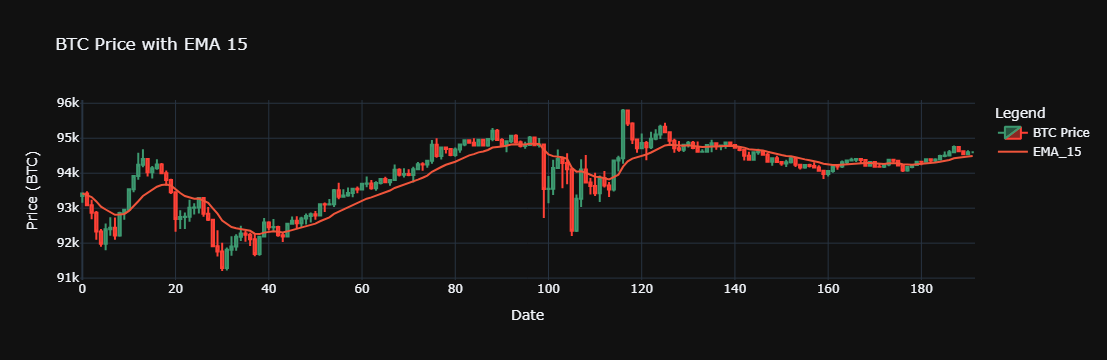

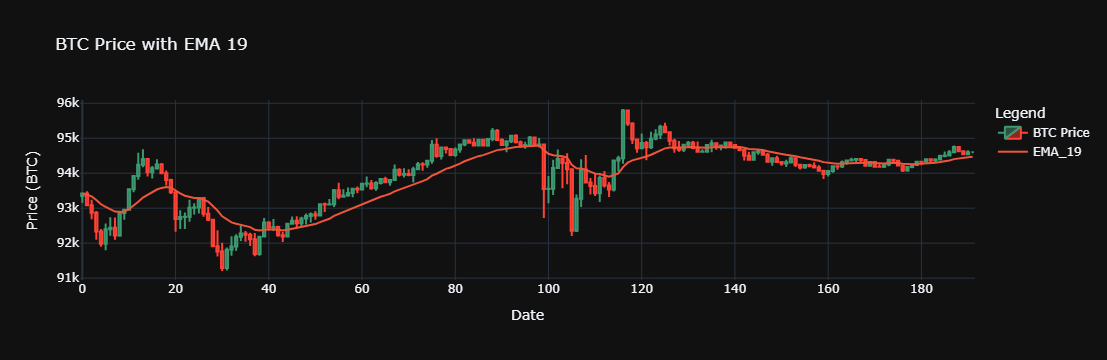

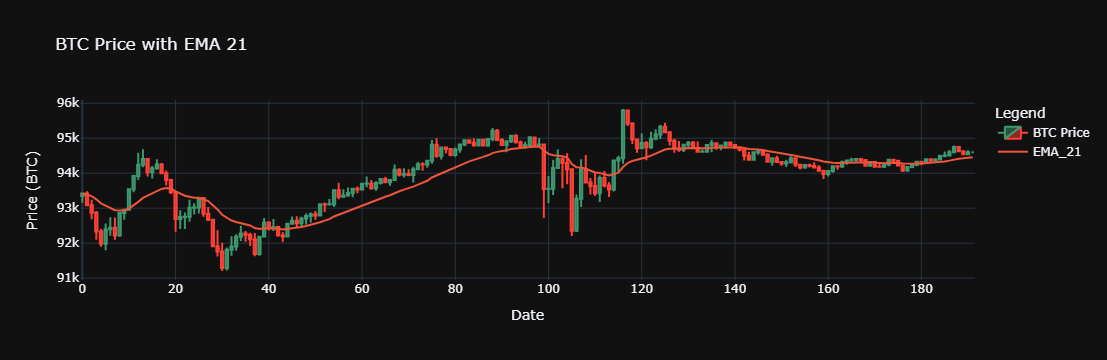

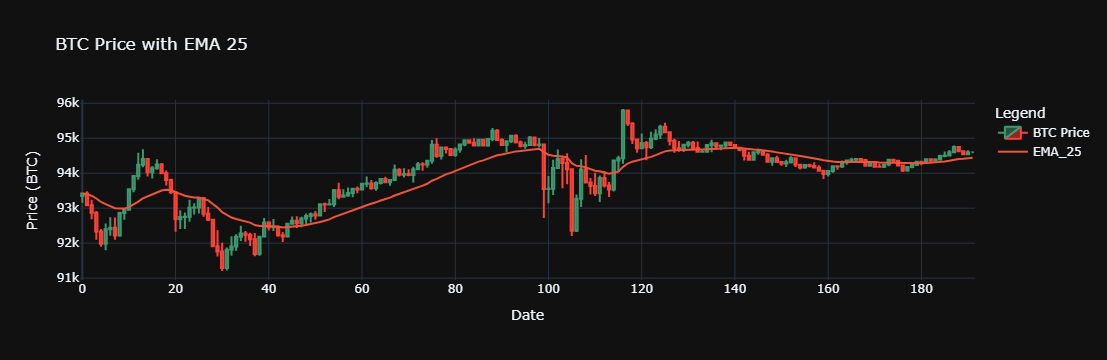

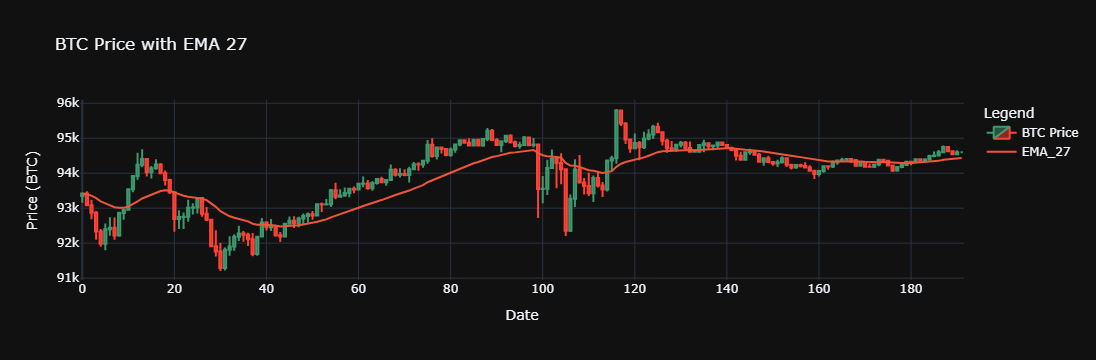

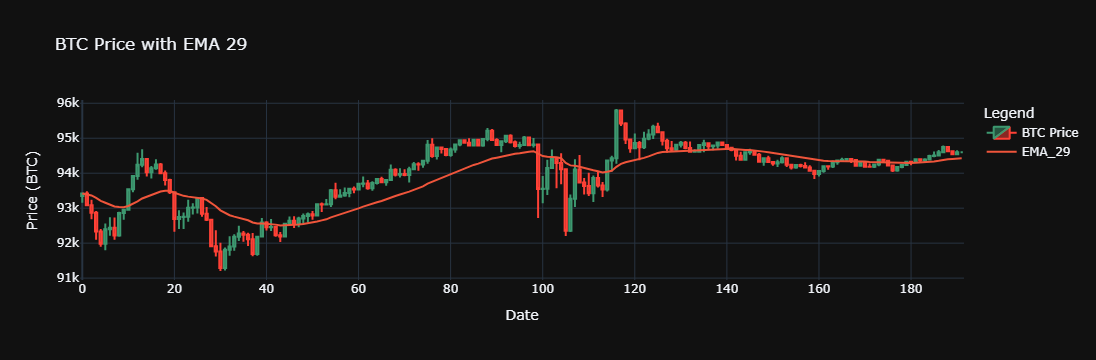

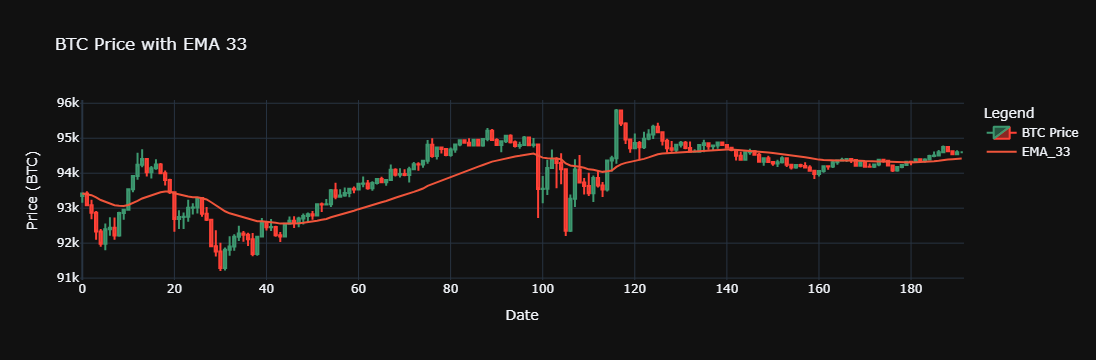

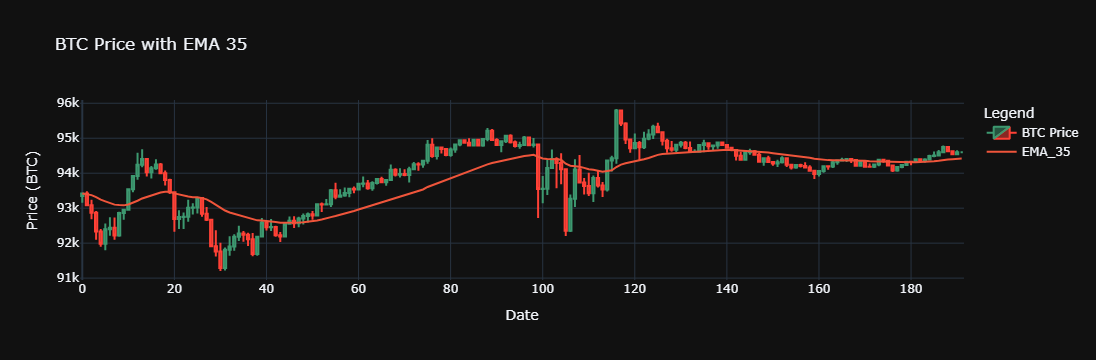

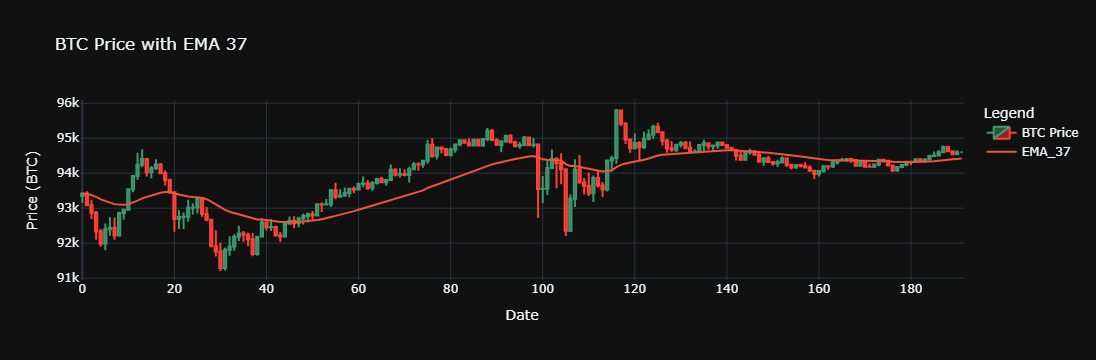

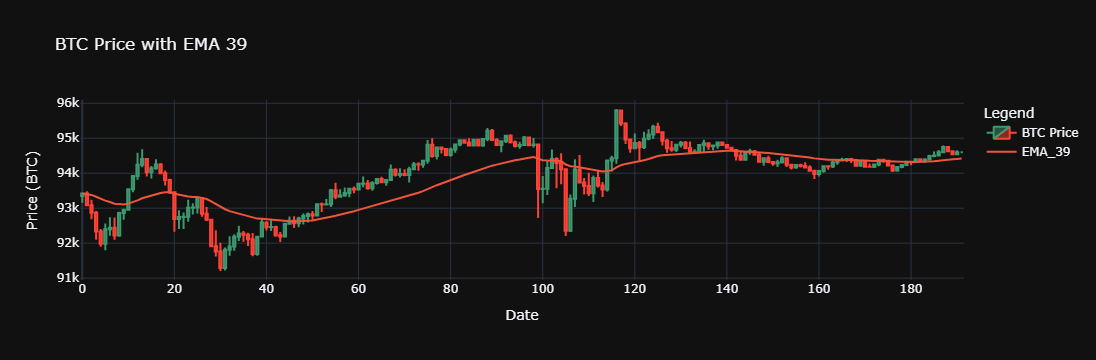

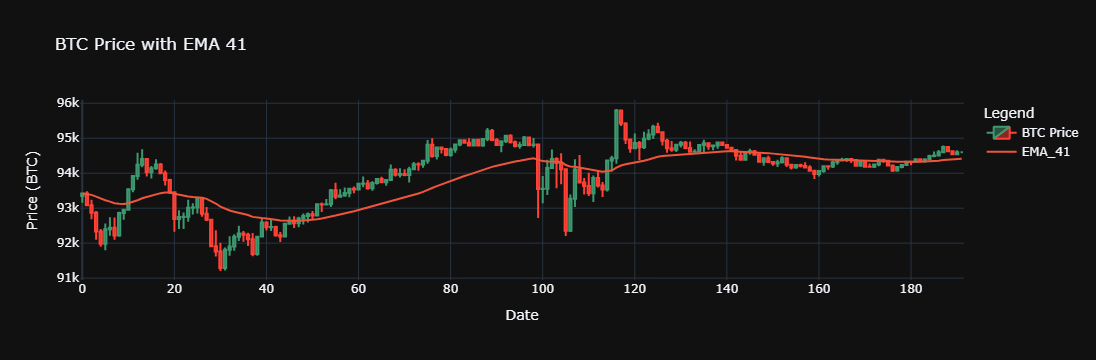

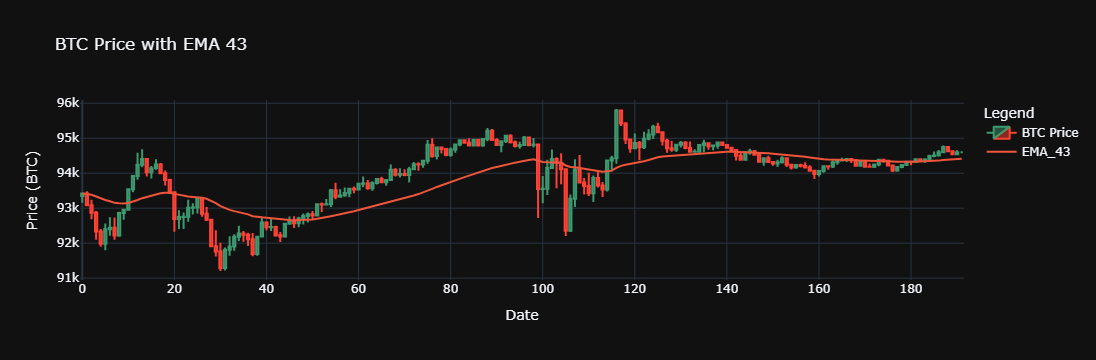

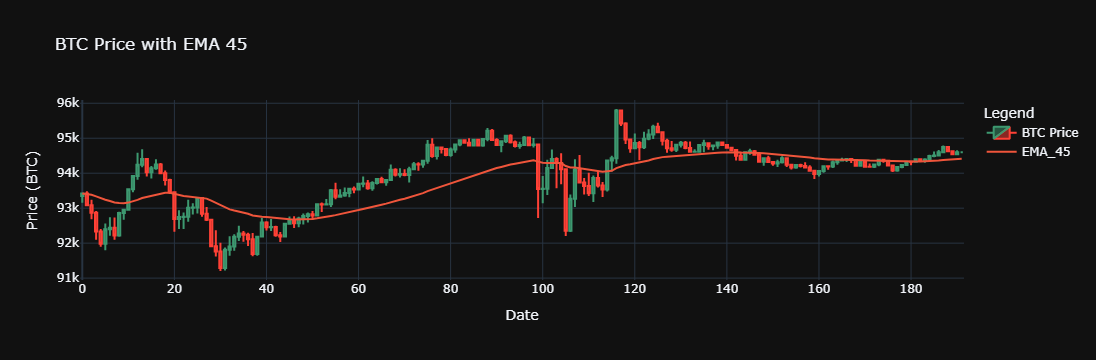

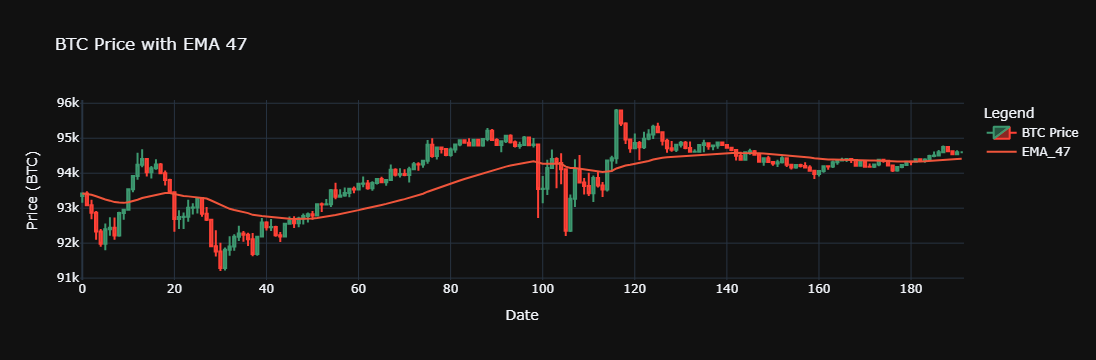

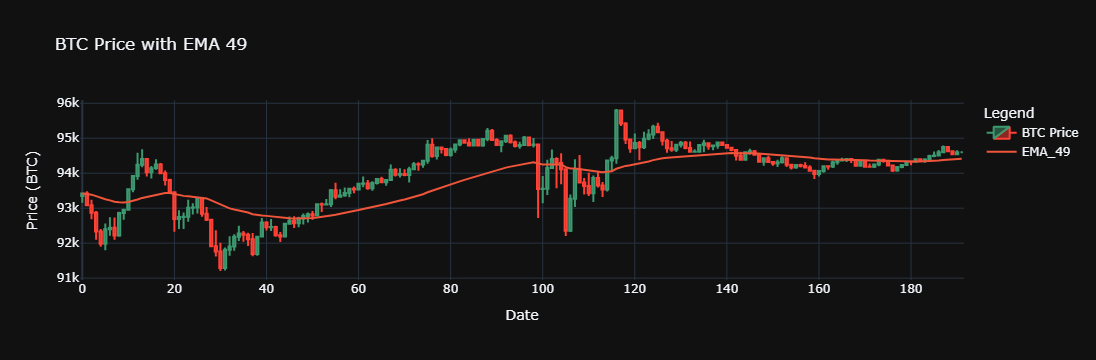

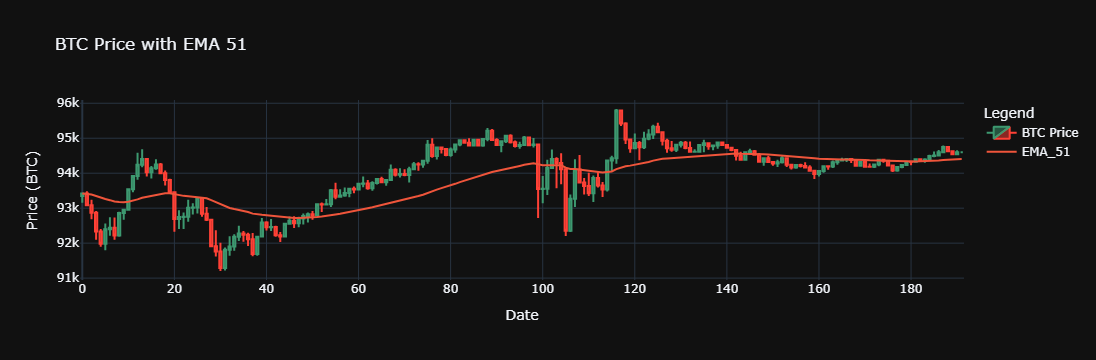

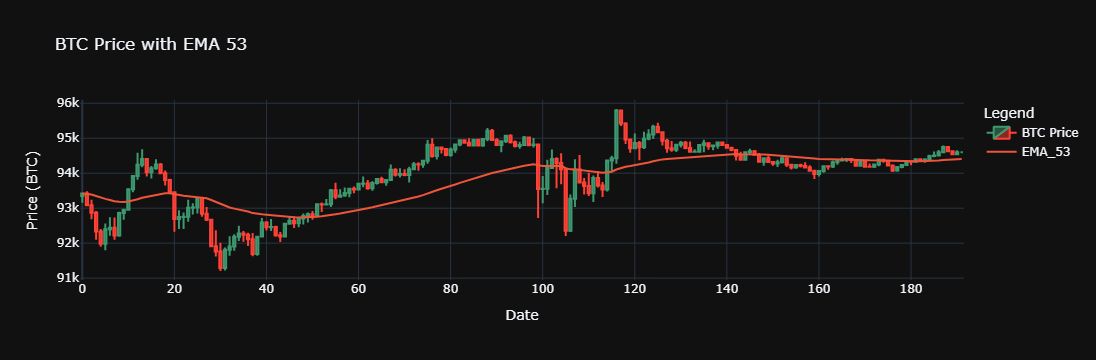

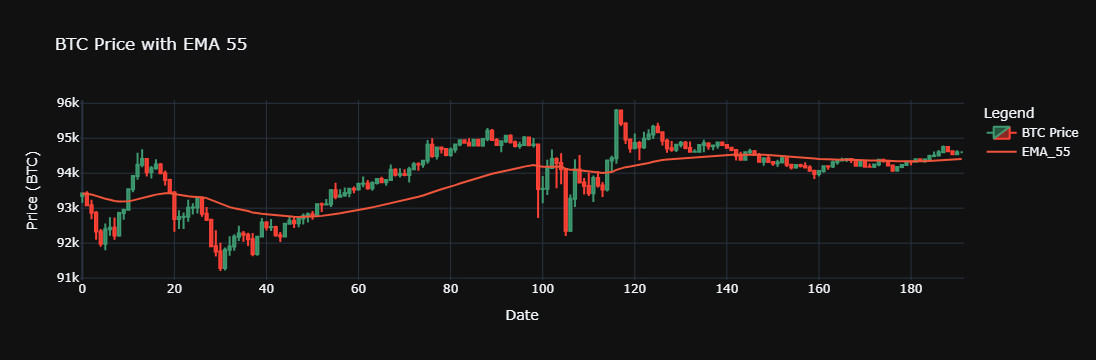

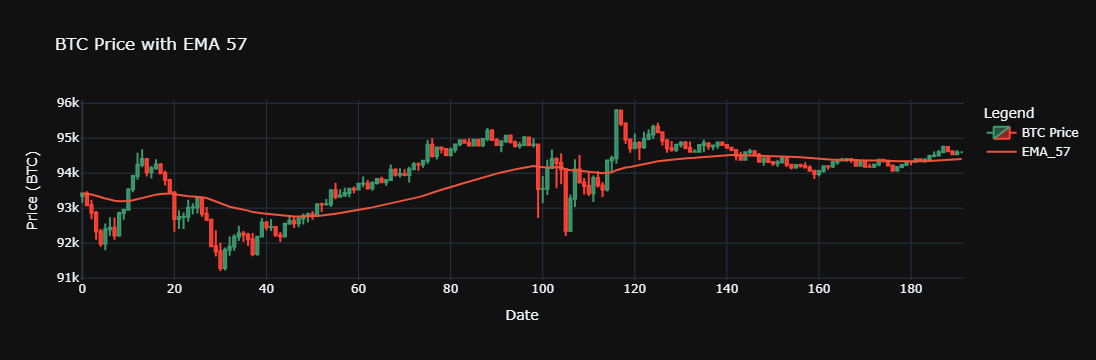

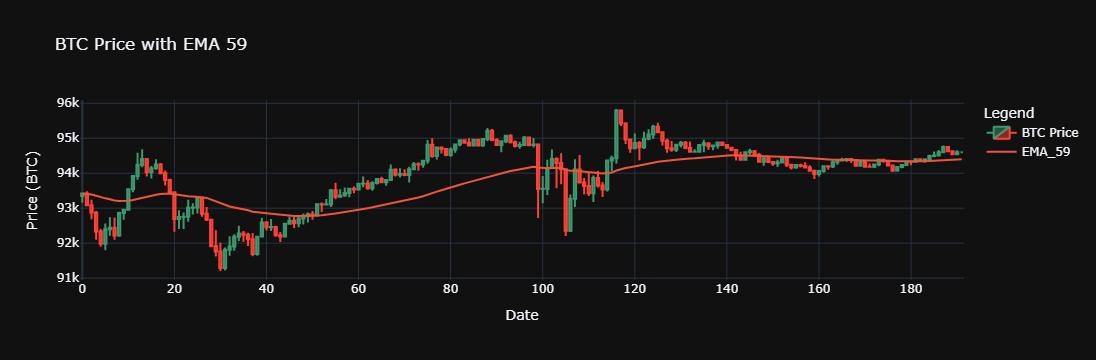

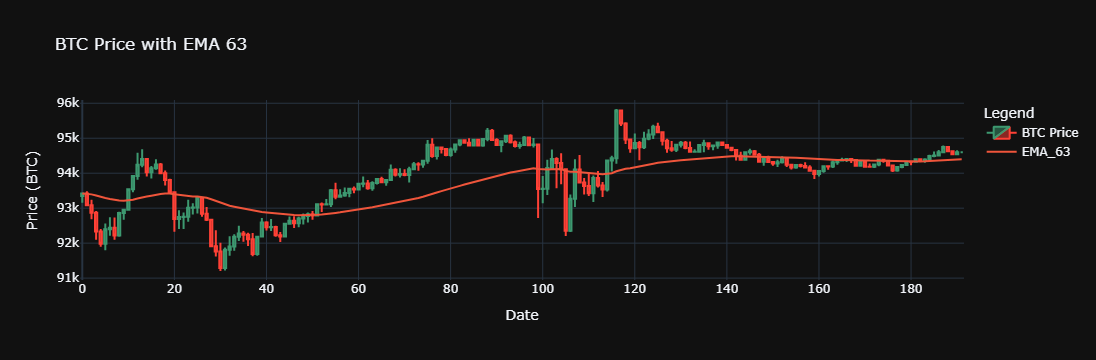

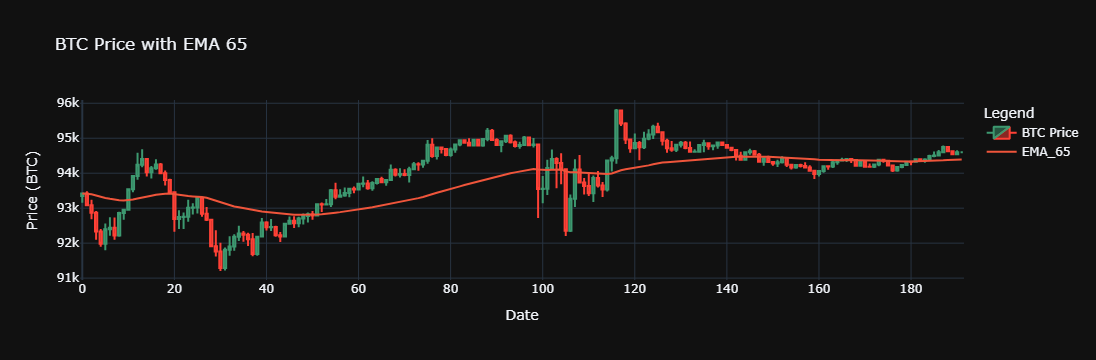

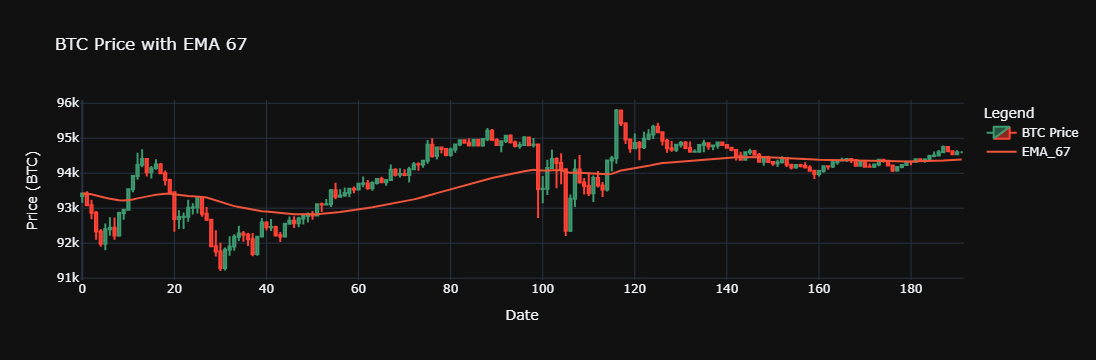

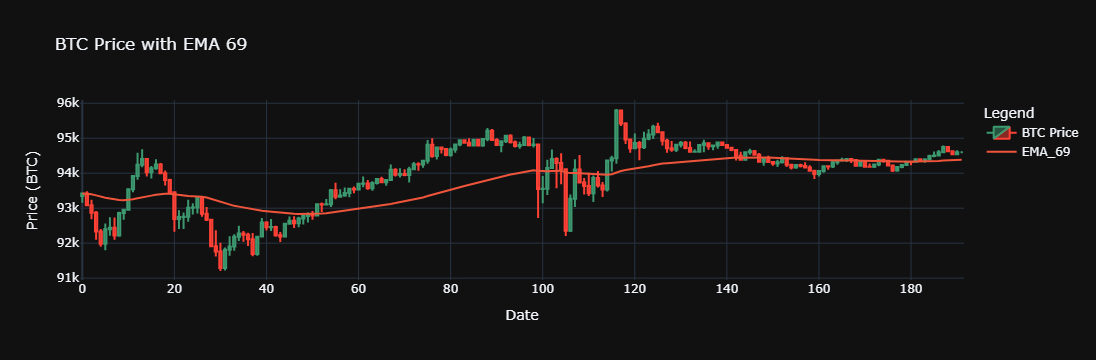

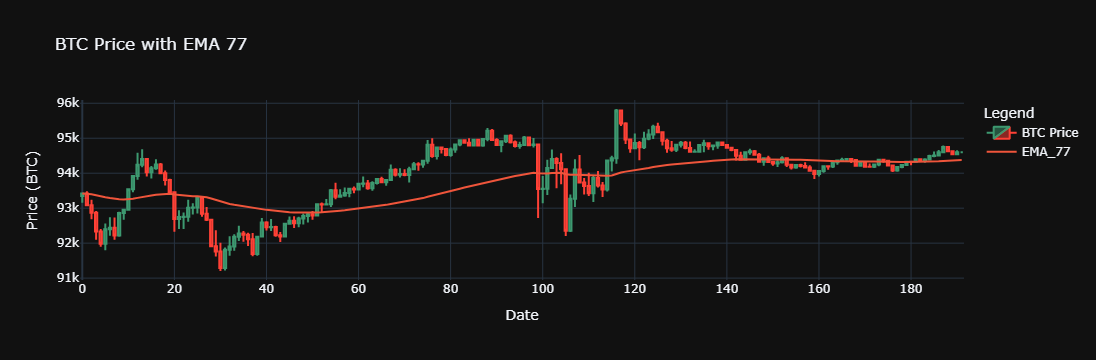

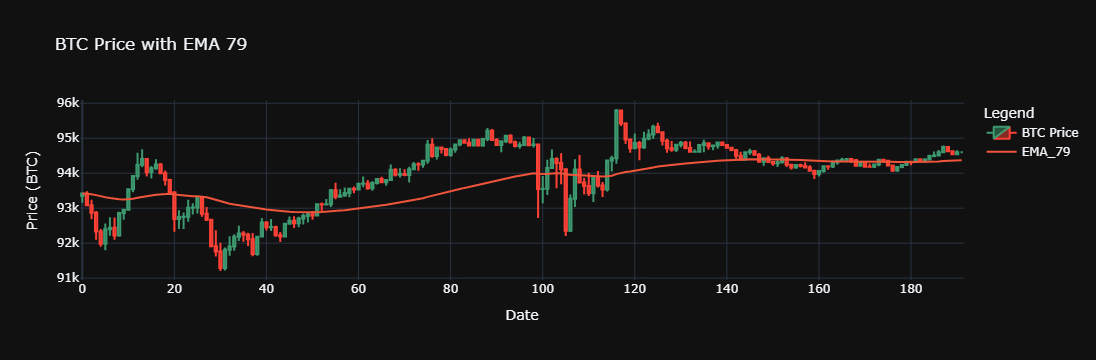

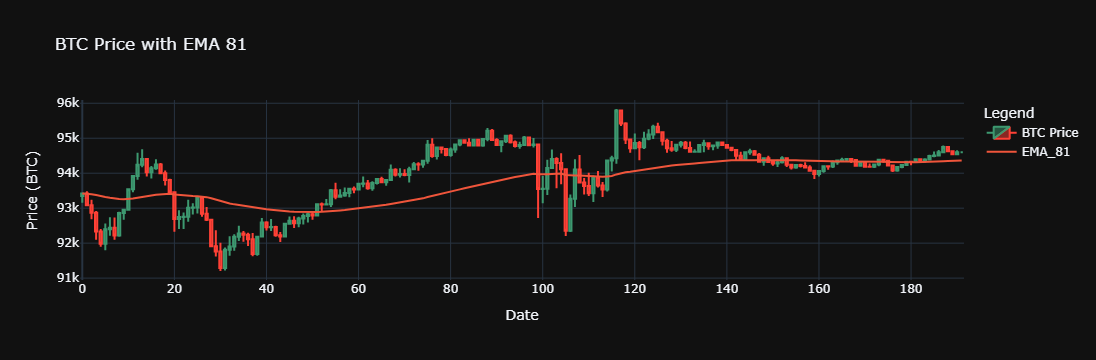

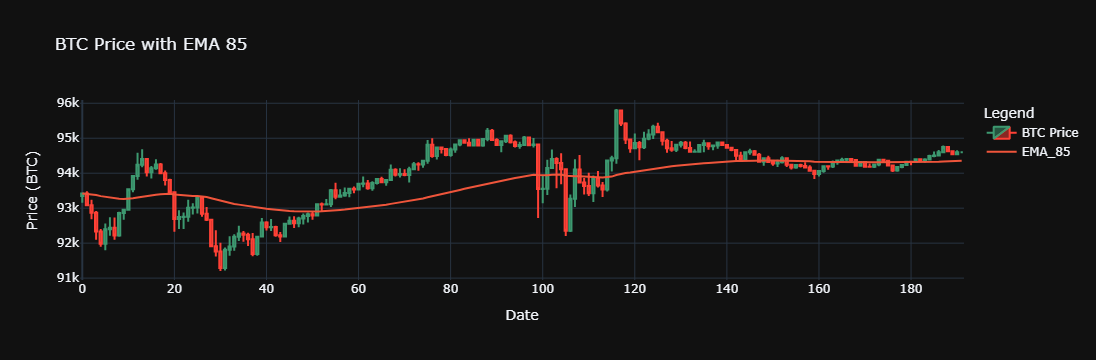

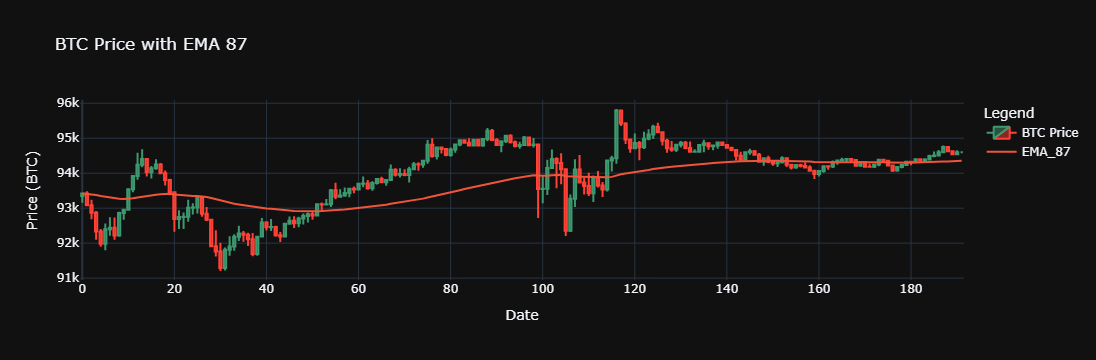

In [77]:
# results = identify_best_ma_ema_and_plot(btc_df)
best_metric, all_metrics_df = identify_best_ma_ema_and_plot(btc_df)

In [79]:
all_metrics_df

Period  Metric    Velocity  Efficiency  Scaled Velocity  \
0       15  EMA_15  468.498621    0.172414         0.954065   
1       17  EMA_17  478.579000    0.200000         1.000000   
2       19  EMA_19  291.133478    0.086957         0.145843   
3       21  EMA_21  288.555652    0.086957         0.134096   
4       23  EMA_23  259.128182    0.045455         0.000000   
5       25  EMA_25  273.759474    0.052632         0.066672   
6       27  EMA_27  314.913333    0.055556         0.254203   
7       29  EMA_29  314.913333    0.055556         0.254203   
8       31  EMA_31  331.068235    0.058824         0.327819   
9       33  EMA_33  336.457059    0.058824         0.352375   
10      35  EMA_35  383.042632    0.052632         0.564657   
11      37  EMA_37  339.764737    0.000000         0.367447   
12      39  EMA_39  340.537500    0.000000         0.370968   
13      41  EMA_41  335.644706    0.000000         0.348673   
14      43  EMA_43  337.275294    0.000000         0.356103   
15      45  EMA_45  316.954000    0.000000         0.263502   
16      47  EMA_47  320.119412    0.000000         0.277927   
17      49  EMA_49  316.455882    0.000000         0.261233   
18      51  EMA_51  316.455882    0.000000         0.261233   
19      53  EMA_53  321.612353    0.000000         0.284730   
20      55  EMA_55  329.242778    0.000000         0.319500   
21      57  EMA_57  349.065000    0.050000         0.409827   
22      59  EMA_59  382.246364    0.045455         0.561029   
23      61  EMA_61  362.740870    0.043478         0.472145   
24      63  EMA_63  394.928182    0.045455         0.618817   
25      65  EMA_65  403.932500    0.050000         0.659849   
26      67  EMA_67  403.932500    0.050000         0.659849   
27      69  EMA_69  372.238333    0.055556         0.515424   
28      71  EMA_71  351.358500    0.050000         0.420278   
29      73  EMA_73  354.541000    0.050000         0.434780   
30      75  EMA_75  337.923182    0.045455         0.359055   
31      77  EMA_77  337.923182    0.045455         0.359055   
32      79  EMA_79  337.923182    0.045455         0.359055   
33      81  EMA_81  355.584500    0.050000         0.439535   
34      83  EMA_83  355.584500    0.050000         0.439535   
35      85  EMA_85  326.383636    0.045455         0.306472   
36      87  EMA_87  328.970455    0.045455         0.318259   
37      89  EMA_89  328.970455    0.045455         0.318259   

    Scaled Efficiency  Combined Score  
0            0.862069        0.899788  
1            1.000000        1.000000  
2            0.434783        0.316317  
3            0.434783        0.311501  
4            0.227273        0.134091  
5            0.263158        0.182599  
6            0.277778        0.268112  
7            0.277778        0.268112  
8            0.294118        0.307935  
9            0.294118        0.318003  
10           0.263158        0.386773  
11           0.000000        0.150653  
12           0.000000        0.152097  
13           0.000000        0.142956  
14           0.000000        0.146002  
15           0.000000        0.108036  
16           0.000000        0.113950  
17           0.000000        0.107105  
18           0.000000        0.107105  
19           0.000000        0.116739  
20           0.000000        0.130995  
21           0.250000        0.315529  
22           0.227273        0.364113  
23           0.217391        0.321840  
24           0.227273        0.387806  
25           0.250000        0.418038  
26           0.250000        0.418038  
27           0.277778        0.375213  
28           0.250000        0.319814  
29           0.250000        0.325760  
30           0.227273        0.281304  
31           0.227273        0.281304  
32           0.227273        0.281304  
33           0.250000        0.327709  
34           0.250000        0.327709  
35           0.227273        0.259744  
36           0.227273        0.264577  
37           0.227273     

## 7. Calculating the Correlations between BTC and Other Coins

In [81]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

def calculate_correlation_and_sensitivity(base_df, target_df, decimals=4):
    """
    Calculate correlation, sensitivity, and trend direction score between base and target dataframes,
    based on percentage changes in 'close' prices, and compute the weighted combined score.

    Parameters:
        base_df (pd.DataFrame): The base dataframe with a 'close' column.
        target_df (pd.DataFrame): The target dataframe with a 'close' column.
        decimals (int): Number of decimal places for formatting. Default is 4.

    Returns:
        float, float, float, float: Correlation, sensitivity (beta coefficient), trend direction score, and weighted combined score.
    """
    # Calculate percentage changes
    base_pct_change = base_df['close'].pct_change().dropna()
    target_pct_change = target_df['close'].pct_change().dropna()

    # Align indices
    aligned_data = pd.concat([base_pct_change, target_pct_change], axis=1).dropna()
    aligned_data.columns = ['Base_pct_change', 'Target_pct_change']

    # Calculate correlation coefficient
    correlation = aligned_data.corr().iloc[0, 1]

    # Regression for sensitivity (beta coefficient)
    X = aligned_data['Base_pct_change'].values.reshape(-1, 1)
    y = aligned_data['Target_pct_change'].values
    reg = LinearRegression()
    reg.fit(X, y)
    sensitivity = reg.coef_[0]

    # Regression for trend direction score
    indices = np.arange(len(target_df['close'])).reshape(-1, 1)  # Use index as a proxy for time
    target_close = target_df['close'].values
    trend_reg = LinearRegression()
    trend_reg.fit(indices, target_close)
    trend_direction_score = trend_reg.coef_[0]  # Slope of the trend line

    # Scale correlation, sensitivity, and trend direction score to 0-1
    correlation_scaled = (correlation + 1) / 2  # Assuming correlation is in [-1, 1]
    sensitivity_scaled = sensitivity / (abs(sensitivity) + 1)  # Normalize sensitivity for scaling
    trend_direction_scaled = (trend_direction_score - min(trend_direction_score, 0)) / \
                              (max(trend_direction_score, 0) + abs(min(trend_direction_score, 0)))

    # Weighted combined score
    combined_score = (
        0.31 * correlation_scaled +
        0.32 * sensitivity_scaled +
        0.37 * trend_direction_scaled
    )

    # Format results to fixed decimals
    correlation = round(correlation, decimals)
    sensitivity = round(sensitivity, decimals)
    trend_direction_score = round(trend_direction_score, decimals)
    combined_score = round(combined_score, decimals)

    return correlation, sensitivity, trend_direction_score, combined_score

In [85]:
# Fetch and calculate correlation and sensitivity for other coins
coins = ['USDTTRY', 'USDTARS', 'USDTCOP', 'BTCUSDT', 'ETHUSDT', 'DOGEUSDT',
       'USDCUSDT', 'SUIUSDT', 'SOLUSDT', 'XRPUSDT', 'FDUSDUSDT',
       'BIOUSDT', 'PEPEUSDT', 'ADAUSDT', 'ENAUSDT', 'TRXUSDT', 'XLMUSDT',
       'FDUSDTRY', 'BNBUSDT', 'PENGUUSDT', 'HBARUSDT', 'USDTBRL',
       'USUALUSDT', 'PHAUSDT', 'PNUTUSDT', 'LINKUSDT', 'NEIROUSDT',
       'ARBUSDT', 'SHIBUSDT', 'AVAXUSDT', 'WLDUSDT', 'BONKUSDT',
       'MOVEUSDT', 'AAVEUSDT', 'RSRUSDT', 'WIFUSDT', 'SUSHIUSDT',
       'UNIUSDT', 'LTCUSDT', 'STGUSDT', 'TAOUSDT', 'FLOKIUSDT', 'FTMUSDT',
       'GALAUSDT', 'TROYUSDT', 'CRVUSDT', 'ACTUSDT', 'DOTUSDT',
       'SANDUSDT', 'ZENUSDT']

results = []
for coin in coins:
    target_df = fetch_crypto_data(coin, '15m', days=2)
    base_df = fetch_crypto_data('BTCUSDT', '15m', days=2)
    correlation, sensitivity, trend_direction_score, combined_score = calculate_correlation_and_sensitivity(base_df, target_df, 4)
    results.append({'Coin': coin, 'Correlation': correlation, 'Sensitivity': sensitivity, 'trend_direction_score':trend_direction_score , 'Combined Score': combined_score})

results_df = pd.DataFrame(results)

In [86]:
results_df

Coin  Correlation  Sensitivity  trend_direction_score  Combined Score
0     USDTTRY      -0.0156      -0.0013                 0.0009          0.5222
1     USDTARS      -0.1205      -0.0400                 0.0309          0.4940
2     USDTCOP      -0.1578      -0.0830                -0.0588          0.1060
3     BTCUSDT       1.0000       1.0000                10.5851          0.8400
4     ETHUSDT       0.9169       1.0560                 0.0224          0.8315
5    DOGEUSDT       0.8537       1.3793                 0.0001          0.8428
6    USDCUSDT       0.0278       0.0007                 0.0000          0.5295
7     SUIUSDT       0.7276       1.4053                 0.0023          0.8247
8     SOLUSDT       0.8667       1.3293                -0.0119          0.4720
9     XRPUSDT       0.8125       1.1324                 0.0005          0.8209
10  FDUSDUSDT       0.2032       0.0054                 0.0000          0.5582
11    BIOUSDT       0.5619       1.5547                -0.0005          0.4368
12   PEPEUSDT       0.8295       1.6068                 0.0000          0.8508
13    ADAUSDT       0.8180       1.5976                 0.0001          0.8486
14    ENAUSDT       0.7616       1.9759                -0.0001          0.4855
15    TRXUSDT       0.8583       0.6468                 0.0000          0.7837
16    XLMUSDT       0.7340       1.5249                 0.0001          0.8320
17   FDUSDTRY      -0.0164      -0.0013                 0.0009          0.5221
18    BNBUSDT       0.8387       0.6489                 0.0436          0.7809
19  PENGUUSDT       0.7156       1.8882                -0.0000          0.4751
20   HBARUSDT       0.8211       1.5343                 0.0001          0.8460
21    USDTBRL      -0.2299      -0.0615                 0.0004          0.4708
22  USUALUSDT       0.4491       1.8382                -0.0004          0.4319
23    PHAUSDT       0.4414       1.1721                 0.0002          0.7661
24   PNUTUSDT       0.7905       1.8771                -0.0000          0.4863
25   LINKUSDT       0.8566       1.3829                 0.0020          0.8435
26  NEIROUSDT       0.7796       1.7654                 0.0000          0.8501
27    ARBUSDT       0.8502       1.5006                -0.0001          0.4788
28   SHIBUSDT       0.8176       1.2447                 0.0000          0.8292
29   AVAXUSDT       0.8733       1.3805                -0.0004          0.4759
30    WLDUSDT       0.8096       1.5869                 0.0002          0.8468
31   BONKUSDT       0.8455       1.6934                 0.0000          0.8572
32   MOVEUSDT       0.5709       1.4233                -0.0001          0.4314
33   AAVEUSDT       0.8223       1.4748                 0.0021          0.8431
34    RSRUSDT       0.8253       1.7519                 0.0000          0.8566
35    WIFUSDT       0.7562       1.7566                -0.0000          0.4761
36  SUSHIUSDT       0.8314       1.7583                 0.0000          0.8578
37    UNIUSDT       0.7617       1.2523                 0.0064          0.8210
38    LTCUSDT       0.8056       1.1087                 0.0050          0.8181
39    STGUSDT       0.5873       1.1779                -0.0001          0.4191
40    TAOUSDT       0.7821       1.6071                -0.0595          0.4735
41  FLOKIUSDT       0.8583       1.4456                 0.0000          0.8472
42    FTMUSDT       0.5134       1.3027                 0.0004          0.7856
43   GALAUSDT       0.8387       1.7354                 0.0000          0.8580
44   TROYUSDT       0.7039       1.6187                 0.0000          0.8319
45    CRVUSDT       0.8204       1.8835                 0.0000          0.8612
46    ACTUSDT       0.7215       1.8544                -0.0001          0.4747
47    DOTUSDT       0.8733       1.4213                 0.0004          0.8482
48   SANDUSDT       0.7804       1.5158                 0.0000          0.8388
49    ZENUSDT       0.5498       1.4719                 0.0

## 8. Suggesting Trades

In [89]:
def suggest_trades(base_df, target_df, best_metric, trend):
    """Suggest long or short trades based on trend with detailed conditions."""
    high = target_df['high'].max()
    low = target_df['low'].min()
    variance = (high - low) / 6  # Adjusted variance division
    take_profit = variance
    stop_loss = take_profit / 4

    target_df['signal'] = None
    target_df['take_profit'] = None
    target_df['stop_loss'] = None

    latest_row = target_df.iloc[-1]

    if trend == 'Positive' and latest_row['close'] > latest_row[best_metric]:
        target_df.loc[target_df.index[-1], 'signal'] = 'Long'
        target_df.loc[target_df.index[-1], 'take_profit'] = latest_row[best_metric] + take_profit
        target_df.loc[target_df.index[-1], 'stop_loss'] = latest_row[best_metric] - stop_loss
    elif trend == 'Negative' and latest_row['close'] < latest_row[best_metric]:
        target_df.loc[target_df.index[-1], 'signal'] = 'Short'
        target_df.loc[target_df.index[-1], 'take_profit'] = latest_row[best_metric] - take_profit
        target_df.loc[target_df.index[-1], 'stop_loss'] = latest_row[best_metric] + stop_loss

    return target_df

In [93]:
# Testing the Function
# Getting the best coin:
if btc_trend == 'Positive':
    # Sort by highest Combined Score
    best_coin = results_df.sort_values(['Combined Score'], ascending=False).iloc[0]['Coin']
else:
    # Sort by lowest trend_direction_score, then highest correlation, then highest sensitivity
    best_coin = results_df.sort_values(
        ['Trend Direction Score', 'Correlation', 'Sensitivity'],
        ascending=[True, False, False]
    ).iloc[0]['Coin']
    
best_coin_df = fetch_crypto_data(best_coin, '15m')

# Calculate the EMA for the best metric
best_coin_df[best_metric] = best_coin_df['close'].ewm(span=int(best_metric.split('_')[1]), adjust=False).mean()

# Suggest trades for the target coin
best_coin_df = suggest_trades(btc_df, best_coin_df, best_metric, btc_trend)
best_coin_df

timestamp    open    high     low   close    volume    EMA_17  \
0   2025-01-08 13:15:00  0.8576  0.8622  0.8549  0.8582  602781.0  0.858200   
1   2025-01-08 13:30:00  0.8582  0.8596  0.8499  0.8537  530694.1  0.857700   
2   2025-01-08 13:45:00  0.8544  0.8552  0.8507  0.8512  326454.5  0.856978   
3   2025-01-08 14:00:00  0.8511  0.8593  0.8511  0.8537  180031.8  0.856614   
4   2025-01-08 14:15:00  0.8538  0.8580  0.8504  0.8551  220738.0  0.856445   
..                  ...     ...     ...     ...     ...       ...       ...   
283 2025-01-11 12:00:00  0.8252  0.8280  0.8203  0.8208  429901.9  0.818100   
284 2025-01-11 12:15:00  0.8208  0.8235  0.8182  0.8210  280693.7  0.818422   
285 2025-01-11 12:30:00  0.8210  0.8216  0.8160  0.8198  827667.7  0.818575   
286 2025-01-11 12:45:00  0.8198  0.8213  0.8178  0.8185  170923.3  0.818567   
287 2025-01-11 13:00:00  0.8189  0.8207  0.8145  0.8152  133849.7  0.818193   

    signal take_profit stop_loss  
0     None        None      None  
1     None        None      None  
2     None        None      None  
3     None        None      None  
4     None        None      None  
..     ...         ...       ...  
283   None        None      None  
284   None        None      None  
285   None        None      None  
286   None        None      None  
287   None        None      None  

[288 rows x 10 columns]

In [97]:
btc_trend

'Positive'

## 9. Plotting Suggesting Trades

In [41]:
def plot_candlestick_with_signals(df, metric_list, title, plot_positions=True, future_time_minutes=300, height=500):
    """Plot candlestick chart with optional trade signals and multiple EMAs/MAs, including y-axis adjustments."""
    future_time = df['timestamp'].iloc[-1] + timedelta(minutes=future_time_minutes)

    fig = go.Figure(data=[go.Candlestick(x=df['timestamp'],
                                         open=df['open'],
                                         high=df['high'],
                                         low=df['low'],
                                         close=df['close'])])

    for metric in metric_list:
        fig.add_trace(go.Scatter(x=df['timestamp'], y=df[metric], mode='lines', name=metric))

    if plot_positions and 'signal' in df.columns:
        last_signal_row = df.iloc[-1]
        if last_signal_row['signal'] == 'Long':
            fig.add_shape(type="rect",
                          x0=last_signal_row['timestamp'], x1=future_time,
                          y0=last_signal_row[metric_list[0]], y1=last_signal_row['take_profit'],
                          fillcolor="green", opacity=0.2, line_width=0)
            fig.add_shape(type="rect",
                          x0=last_signal_row['timestamp'], x1=future_time,
                          y0=last_signal_row[metric_list[0]], y1=last_signal_row['stop_loss'],
                          fillcolor="red", opacity=0.2, line_width=0)
        elif last_signal_row['signal'] == 'Short':
            fig.add_shape(type="rect",
                          x0=last_signal_row['timestamp'], x1=future_time,
                          y0=last_signal_row[metric_list[0]], y1=last_signal_row['stop_loss'],
                          fillcolor="red", opacity=0.2, line_width=0)
            fig.add_shape(type="rect",
                          x0=last_signal_row['timestamp'], x1=future_time,
                          y0=last_signal_row[metric_list[0]], y1=last_signal_row['take_profit'],
                          fillcolor="green", opacity=0.2, line_width=0)

    # Enable zoom and pan for the y-axis
    fig.update_layout(
        title=title,
        xaxis_title='Time',
        yaxis_title='Price',
        height=height,
        yaxis=dict(
            fixedrange=False,  # Allow vertical zoom
            rangemode='normal',  # Ensure y-axis is dynamic
        ),
        xaxis=dict(
            rangeslider=dict(visible=True),  # Horizontal range slider
        )
    )

    return fig

In [99]:
plot_candlestick_with_signals(best_coin_df, [best_metric], f"{best_coin} with Suggested Position", future_time_minutes=300, height=400)

## 10. Backtesting

In [45]:
def ema_touch_strategy_with_plot(coin, ema_number, budget, trading_fee=0.001, interval="15m", days=30, chart_height=800, trend="positive"):
    """
    Backtest the strategy based on the trend (long or short) using EMA touch methodology.
    Plot results with TradingView-style visuals.

    Args:
        coin (str): The cryptocurrency symbol (e.g., "BTCUSDT").
        ema_number (int): The EMA period to use (e.g., 20, 50).
        budget (float): The initial budget for trading.
        trading_fee (float): The trading fee per trade (default: 0.1%).
        interval (str): The interval for fetching data (default: "15m").
        days (int): Number of days of historical data to fetch (default: 30).
        chart_height (int): Height of the candlestick chart in pixels (default: 800).
        trend (str): "positive" for long trades, "negative" for short trades.

    Returns:
        dict: A dictionary containing:
            - Number of trades
            - Profit & Loss
            - Win %
            - Ending Total Budget
            - DataFrame of trades with details
            - Candlestick plot with trades and EMA
    """
    # Fetch historical data for the coin
    df = fetch_crypto_data(coin, interval, days)

    # Calculate the specified EMA
    ema_col = f"EMA_{ema_number}"
    df[ema_col] = df['close'].ewm(span=ema_number, adjust=False).mean()

    # Calculate variance and risk-reward parameters
    variance = (df['high'].max() - df['low'].min())
    take_profit_factor = variance / 8
    stop_loss_factor = take_profit_factor / 2

    # Initialize trade tracking variables
    trades = []
    current_budget = budget
    win_count = 0
    total_trades = 0
    active_trade = False  # Track if a trade is active
    entry_price = 0
    entry_time = None

    buy_markers = []
    sell_markers = []
    long_positions = []

    # Loop through the dataset to simulate trades
    for i in range(1, len(df)):
        previous_price = df['close'].iloc[i - 1]
        current_price = df['close'].iloc[i]
        previous_ema = df[ema_col].iloc[i - 1]
        current_ema = df[ema_col].iloc[i]
        low_price = df['low'].iloc[i]
        high_price = df['high'].iloc[i]

        if trend == "positive":
            # Enter a long trade only if no active trade exists
            if not active_trade and previous_price > previous_ema and low_price <= current_ema:
                take_profit = current_price + take_profit_factor
                stop_loss = current_price - stop_loss_factor
                trade_amount = current_budget / current_price  # Buy as much as the budget allows
                quantity_bought = trade_amount
                entry_price = current_price
                entry_time = df['timestamp'].iloc[i]
                active_trade = True
                total_trades += 1

                buy_markers.append((entry_time, entry_price))

            # Exit the active long trade if conditions are met
            if active_trade:
                if high_price >= take_profit:  # Take profit reached
                    profit = quantity_bought * (take_profit - entry_price)
                    current_budget += profit - trading_fee * entry_price * quantity_bought
                    win_count += 1
                    trades.append({
                        "Trade Type": "Long",
                        "Buy Price": entry_price,
                        "Sell Price": take_profit,
                        "Quantity Bought": quantity_bought,
                        "Profit": profit,
                        "Loss": 0,
                        "Stop Loss": stop_loss,
                        "Entry Time": entry_time,
                        "Exit Time": df['timestamp'].iloc[i]
                    })
                    sell_markers.append((df['timestamp'].iloc[i], take_profit))
                    long_positions.append({
                        "entry_time": entry_time,
                        "exit_time": df['timestamp'].iloc[i],
                        "entry_price": entry_price,
                        "take_profit": take_profit,
                        "stop_loss": stop_loss,
                        "outcome": "profit"
                    })
                    active_trade = False

                elif low_price <= stop_loss:  # Stop loss reached
                    loss = quantity_bought * (entry_price - stop_loss)
                    current_budget -= loss + trading_fee * entry_price * quantity_bought
                    trades.append({
                        "Trade Type": "Long",
                        "Buy Price": entry_price,
                        "Sell Price": stop_loss,
                        "Quantity Bought": quantity_bought,
                        "Profit": 0,
                        "Loss": loss,
                        "Stop Loss": stop_loss,
                        "Entry Time": entry_time,
                        "Exit Time": df['timestamp'].iloc[i]
                    })
                    sell_markers.append((df['timestamp'].iloc[i], stop_loss))
                    long_positions.append({
                        "entry_time": entry_time,
                        "exit_time": df['timestamp'].iloc[i],
                        "entry_price": entry_price,
                        "take_profit": take_profit,
                        "stop_loss": stop_loss,
                        "outcome": "loss"
                    })
                    active_trade = False

        elif trend == "negative":
            # Enter a short trade only if no active trade exists
            if not active_trade and previous_price < previous_ema and high_price >= current_ema:
                take_profit = current_price - take_profit_factor
                stop_loss = current_price + stop_loss_factor
                trade_amount = current_budget / current_price  # Sell as much as the budget allows
                quantity_sold = trade_amount
                entry_price = current_price
                entry_time = df['timestamp'].iloc[i]
                active_trade = True
                total_trades += 1

                sell_markers.append((entry_time, entry_price))

            # Exit the active short trade if conditions are met
            if active_trade:
                if low_price <= take_profit:  # Take profit reached
                    profit = quantity_sold * (entry_price - take_profit)
                    current_budget += profit - trading_fee * entry_price * quantity_sold
                    win_count += 1
                    trades.append({
                        "Trade Type": "Short",
                        "Sell Price": entry_price,
                        "Buy Back Price": take_profit,
                        "Quantity Sold": quantity_sold,
                        "Profit": profit,
                        "Loss": 0,
                        "Stop Loss": stop_loss,
                        "Entry Time": entry_time,
                        "Exit Time": df['timestamp'].iloc[i]
                    })
                    buy_markers.append((df['timestamp'].iloc[i], take_profit))
                    long_positions.append({
                        "entry_time": entry_time,
                        "exit_time": df['timestamp'].iloc[i],
                        "entry_price": entry_price,
                        "take_profit": take_profit,
                        "stop_loss": stop_loss,
                        "outcome": "profit"
                    })
                    active_trade = False

                elif high_price >= stop_loss:  # Stop loss reached
                    loss = quantity_sold * (stop_loss - entry_price)
                    current_budget -= loss + trading_fee * entry_price * quantity_sold
                    trades.append({
                        "Trade Type": "Short",
                        "Sell Price": entry_price,
                        "Buy Back Price": stop_loss,
                        "Quantity Sold": quantity_sold,
                        "Profit": 0,
                        "Loss": loss,
                        "Stop Loss": stop_loss,
                        "Entry Time": entry_time,
                        "Exit Time": df['timestamp'].iloc[i]
                    })
                    buy_markers.append((df['timestamp'].iloc[i], stop_loss))
                    long_positions.append({
                        "entry_time": entry_time,
                        "exit_time": df['timestamp'].iloc[i],
                        "entry_price": entry_price,
                        "take_profit": take_profit,
                        "stop_loss": stop_loss,
                        "outcome": "loss"
                    })
                    active_trade = False

    # Calculate metrics
    win_rate = (win_count / total_trades) * 100 if total_trades > 0 else 0
    profit_loss = current_budget - budget

    # Convert trades to a DataFrame
    trades_df = pd.DataFrame(trades)

    # Plot candlestick chart with EMA and trades
    fig = go.Figure()

    # Add candlestick chart
    fig.add_trace(go.Candlestick(
        x=df['timestamp'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        name="Candlestick",
        increasing=dict(line=dict(width=3)),
        decreasing=dict(line=dict(width=3))
    ))

    # Add EMA line
    fig.add_trace(go.Scatter(
        x=df['timestamp'],
        y=df[ema_col],
        mode='lines',
        name=f"EMA {ema_number}",
        line=dict(color='blue', width=2)
    ))

    # Add TradingView-style long positions with dynamic background color
    for pos in long_positions:
        color = "rgba(0,255,0,0.2)" if pos["outcome"] == "profit" else "rgba(255,0,0,0.2)"
        fig.add_shape(
            type="rect",
            x0=pos["entry_time"],
            x1=pos["exit_time"],
            y0=pos["stop_loss"],
            y1=pos["take_profit"],
            fillcolor=color,
            line=dict(width=0)
        )

    # Add buy and sell markers
    for timestamp, price in buy_markers:
        fig.add_trace(go.Scatter(
            x=[timestamp],
            y=[price],
            mode='markers',
            marker=dict(color='green', size=10),
            name="Buy Signal"
        ))

    for timestamp, price in sell_markers:
        fig.add_trace(go.Scatter(
            x=[timestamp],
            y=[price],
            mode='markers',
            marker=dict(color='red', size=10),
            name="Sell Signal"
        ))

    # Update layout for height and background color
    fig.update_layout(
        title=f"{coin} with EMA {ema_number} and Trades",
        xaxis_title="Timestamp",
        yaxis_title="Price",
        height=chart_height,
        template="plotly_dark",  # Set to dark mode
        paper_bgcolor="black",  # Set the background to black
        plot_bgcolor="black"    # Set the plot area to black
    )

    return {
        "Number of Trades": total_trades,
        "Profit & Loss": profit_loss,
        "Win %": win_rate,
        "Ending Total Budget": current_budget,
        "Trades DataFrame": trades_df,
        "Candlestick Plot": fig
    }


In [57]:
# Example
result = ema_touch_strategy_with_plot(
    coin="GALAUSDT",
    ema_number=15,
    budget=3000,
    trading_fee=0.001,
    interval="1h",
    days=7,
    chart_height=700,
    trend="negative"  # Short trades only
)

# Display results
print(f"Number of Trades: {result['Number of Trades']}")
print(f"Profit & Loss: ${result['Profit & Loss']:.2f}")
print(f"Win %: {result['Win %']:.2f}%")
print(f"Ending Total Budget: ${result['Ending Total Budget']:.2f}")

# Show trades DataFrame
print(result['Trades DataFrame'].head())

# Display the candlestick plot
result['Candlestick Plot'].show()


Number of Trades: 13
Profit & Loss: $238.72
Win %: 46.15%
Ending Total Budget: $3238.72
  Trade Type  Sell Price  Buy Back Price  Quantity Sold      Profit  \
0      Short     0.04250        0.041021   70588.235294  104.382353   
1      Short     0.04160        0.042339   74552.460407    0.000000   
2      Short     0.04209        0.042829   72301.229394    0.000000   
3      Short     0.04170        0.042439   71622.490766    0.000000   
4      Short     0.04217        0.042909   69497.636423    0.000000   

        Loss  Stop Loss          Entry Time           Exit Time  
0   0.000000   0.043239 2025-01-04 17:00:00 2025-01-05 10:00:00  
1  55.122225   0.042339 2025-01-05 15:00:00 2025-01-05 20:00:00  
2  53.457721   0.042829 2025-01-06 01:00:00 2025-01-06 02:00:00  
3  52.955879   0.042439 2025-01-06 08:00:00 2025-01-06 08:00:00  
4  51.384815   0.042909 2025-01-06 09:00:00 2025-01-06 11:00:00  


In [49]:
result['Trades DataFrame']

Trade Type  Sell Price  Buy Back Price  Quantity Sold      Profit  \
0       Short      232.54      225.111250      12.901006   95.838350   
1       Short      225.61      218.181250      13.708782  101.839116   
2       Short      221.23      224.944375      14.426545    0.000000   
3       Short      221.36      213.931250      14.161580  105.202841   
4       Short      218.51      222.224375      14.813397    0.000000   
5       Short      217.73      210.301250      14.598889  108.451496   
6       Short      210.31      202.881250      15.614517  115.996340   
7       Short      189.89      193.604375      17.887205    0.000000   
8       Short      192.94      185.511250      17.242485  128.090109   
9       Short      184.32      176.891250      18.725740  139.108840   
10      Short      178.31      182.024375      20.117692    0.000000   
11      Short      186.24      189.954375      18.840603    0.000000   
12      Short      196.98      189.551250      17.440268  129.559388   
13      Short      188.82      192.534375      18.861921    0.000000   
14      Short      185.81      189.524375      18.771251    0.000000   
15      Short      195.14      187.711250      17.498590  129.992649   
16      Short      191.57      195.284375      18.485425    0.000000   
17      Short      190.06      193.774375      18.252393    0.000000   
18      Short      194.02      197.734375      17.512547    0.000000   

         Loss   Stop Loss          Entry Time           Exit Time  
0    0.000000  236.254375 2024-12-12 14:00:00 2024-12-13 01:00:00  
1    0.000000  229.324375 2024-12-13 11:00:00 2024-12-14 17:00:00  
2   53.585599  224.944375 2024-12-15 01:00:00 2024-12-15 23:00:00  
3    0.000000  225.074375 2024-12-16 04:00:00 2024-12-16 11:00:00  
4   55.022513  222.224375 2024-12-16 16:00:00 2024-12-17 09:00:00  
5    0.000000  221.444375 2024-12-18 15:00:00 2024-12-18 20:00:00  
6    0.000000  214.024375 2024-12-19 06:00:00 2024-12-19 15:00:00  
7   66.439788  193.604375 2024-12-20 15:00:00 2024-12-20 23:00:00  
8    0.000000  196.654375 2024-12-21 11:00:00 2024-12-21 13:00:00  
9    0.000000  188.034375 2024-12-22 07:00:00 2024-12-22 20:00:00  
10  74.724653  182.024375 2024-12-23 01:00:00 2024-12-23 01:00:00  
11  69.981064  189.954375 2024-12-23 03:00:00 2024-12-23 20:00:00  
12   0.000000  200.694375 2024-12-25 13:00:00 2024-12-26 08:00:00  
13  70.060248  192.534375 2024-12-27 02:00:00 2024-12-27 09:00:00  
14  69.723466  189.524375 2024-12-28 05:00:00 2024-12-28 14:00:00  
15   0.000000  198.854375 2024-12-29 15:00:00 2024-12-30 14:00:00  
16  68.661799  195.284375 2024-12-30 17:00:00 2024-12-30 19:00:00  
17  67.796231  193.774375 2024-12-31 00:00:00 2024-12-31 09:00:00  
18  65.048168  197.734375 2024-12-31 20:00:00 2025-01-02 01:00:00

## 11. Streamlit APP

In [1]:
import streamlit as st
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime, timedelta
from binance.client import Client
from sklearn.linear_model import LinearRegression
from PIL import Image

# Set your Binance API credentials
API_KEY = ''
API_SECRET = ''

# Initialize Binance client
client = Client(API_KEY, API_SECRET)

def fetch_crypto_data(symbol, interval, days=2):
    """Fetch historical data for a given symbol and interval."""
    since = int((datetime.now() - timedelta(days=days)).timestamp() * 1000)
    candles = client.get_klines(symbol=symbol, interval=interval, startTime=since)
    df = pd.DataFrame(candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df

def calculate_regression(df):
    """Calculate regression analysis to determine trend."""
    X = np.arange(len(df)).reshape(-1, 1)
    y = df['close'].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    slope = model.coef_[0]
    return 'Positive' if slope > 0 else 'Negative' if slope < 0 else 'Flat', y_pred

def plot_regression(df, y_pred, height=1000):
    """Plot regression analysis."""
    plt.figure(figsize=(12, height / 100))
    plt.plot(df['timestamp'], df['close'], label='BTC Price', color='blue')
    plt.plot(df['timestamp'], y_pred, label='Regression Line', color='red', linestyle='--')
    plt.title('BTC Price with Regression Line')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    st.pyplot(plt)

def calculate_price_reaction_velocity(df, ema_col, k=5):
    """Calculate Price Reaction Velocity."""
    touches = df[(df['close'].shift(1) > df[ema_col]) & (df['close'] <= df[ema_col]) | 
                 (df['close'].shift(1) < df[ema_col]) & (df['close'] >= df[ema_col])]
    velocities = []
    for idx in touches.index:
        if idx + k < len(df):
            reaction = abs(df.loc[idx + k, 'close'] - df.loc[idx, 'close'])
            velocities.append(reaction)
    return np.mean(velocities) if velocities else 0

def calculate_bounce_efficiency(df, ema_col, k=5, threshold=0.01):
    """Calculate Bounce Efficiency."""
    touches = df[(df['close'].shift(1) > df[ema_col]) & (df['close'] <= df[ema_col]) | 
                 (df['close'].shift(1) < df[ema_col]) & (df['close'] >= df[ema_col])]
    significant_bounces = 0
    for idx in touches.index:
        if idx + k < len(df):
            reaction = abs(df.loc[idx + k, 'close'] - df.loc[idx, 'close'])
            if reaction > threshold * df.loc[idx, 'close']:
                significant_bounces += 1
    return significant_bounces / len(touches) if len(touches) > 0 else 0

def identify_best_ma_ema(df):
    """Identify the best performing MA or EMA using combined metrics."""
    results = []

    # Loop through EMA periods in the specified range
    for period in range(15, 91, 2):
        # Calculate EMA
        df[f'EMA_{period}'] = df['close'].ewm(span=period, adjust=False).mean()

        # Calculate metrics
        velocity = calculate_price_reaction_velocity(df, f'EMA_{period}')
        efficiency = calculate_bounce_efficiency(df, f'EMA_{period}')

        # Handle missing or invalid values for velocity/efficiency
        if velocity is None or efficiency is None:
            velocity = 0
            efficiency = 0

        results.append({
            'Period': period,
            'Metric': f'EMA_{period}',
            'Velocity': velocity,
            'Efficiency': efficiency,
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Scale velocity and efficiency between 0 and 1
    results_df['Scaled Velocity'] = (results_df['Velocity'] - results_df['Velocity'].min()) / \
                                    (results_df['Velocity'].max() - results_df['Velocity'].min())
    results_df['Scaled Efficiency'] = (results_df['Efficiency'] - results_df['Efficiency'].min()) / \
                                       (results_df['Efficiency'].max() - results_df['Efficiency'].min())

    # Calculate the combined score with weights: 41% velocity, 59% efficiency
    results_df['Combined Score'] = 0.41 * results_df['Scaled Velocity'] + 0.59 * results_df['Scaled Efficiency'].fillna(0)

    # Identify the best EMA based on the highest combined score
    best = results_df.sort_values('Combined Score', ascending=False).iloc[0]
    return best['Metric'], results_df

def calculate_correlation_and_sensitivity(base_df, target_df, decimals=4):
    """Calculate correlation and sensitivity between base and target dataframes."""
    # Calculate percentage changes
    base_pct_change = base_df['close'].pct_change().dropna()
    target_pct_change = target_df['close'].pct_change().dropna()

    # Align indices
    aligned_data = pd.concat([base_pct_change, target_pct_change], axis=1).dropna()
    aligned_data.columns = ['Base_pct_change', 'Target_pct_change']

    # Calculate correlation coefficient
    correlation = aligned_data.corr().iloc[0, 1]

    # Regression for sensitivity (beta coefficient)
    X = aligned_data['Base_pct_change'].values.reshape(-1, 1)
    y = aligned_data['Target_pct_change'].values
    reg = LinearRegression()
    reg.fit(X, y)
    sensitivity = reg.coef_[0]

    # Regression for trend direction score
    indices = np.arange(len(target_df['close'])).reshape(-1, 1)  # Use index as a proxy for time
    target_close = target_df['close'].values
    trend_reg = LinearRegression()
    trend_reg.fit(indices, target_close)
    trend_direction_score = trend_reg.coef_[0]  # Slope of the trend line

    # Scale correlation, sensitivity, and trend direction score to 0-1
    correlation_scaled = (correlation + 1) / 2  # Assuming correlation is in [-1, 1]
    sensitivity_scaled = sensitivity / (abs(sensitivity) + 1)  # Normalize sensitivity for scaling
    trend_direction_scaled = (trend_direction_score - min(trend_direction_score, 0)) / \
                              (max(trend_direction_score, 0) + abs(min(trend_direction_score, 0)))

    # Weighted combined score
    combined_score = (
        0.31 * correlation_scaled +
        0.32 * sensitivity_scaled +
        0.37 * trend_direction_scaled
    )

    # Format results to fixed decimals
    correlation = round(correlation, decimals)
    sensitivity = round(sensitivity, decimals)
    trend_direction_score = round(trend_direction_score, decimals)
    combined_score = round(combined_score, decimals)

    return correlation, sensitivity, trend_direction_score, combined_score

def suggest_trades(base_df, target_df, best_metric, trend):
    """Suggest long or short trades based on trend with detailed conditions."""
    high = target_df['high'].max()
    low = target_df['low'].min()
    variance = (high - low) / 5  # Adjusted variance division
    take_profit = variance
    stop_loss = take_profit / 4

    target_df['signal'] = None
    target_df['take_profit'] = None
    target_df['stop_loss'] = None

    latest_row = target_df.iloc[-1]

    if trend == 'Positive' and latest_row['close'] > latest_row[best_metric]:
        target_df.loc[target_df.index[-1], 'signal'] = 'Long'
        target_df.loc[target_df.index[-1], 'take_profit'] = latest_row[best_metric] + take_profit
        target_df.loc[target_df.index[-1], 'stop_loss'] = latest_row[best_metric] - stop_loss
    elif trend == 'Negative' and latest_row['close'] < latest_row[best_metric]:
        target_df.loc[target_df.index[-1], 'signal'] = 'Short'
        target_df.loc[target_df.index[-1], 'take_profit'] = latest_row[best_metric] - take_profit
        target_df.loc[target_df.index[-1], 'stop_loss'] = latest_row[best_metric] + stop_loss

    return target_df

def plot_candlestick_with_signals(df, metric_list, title, plot_positions=True, future_time_minutes=300, height=500):
    """Plot candlestick chart with optional trade signals and multiple EMAs/MAs."""
    future_time = df['timestamp'].iloc[-1] + timedelta(minutes=future_time_minutes)

    fig = go.Figure(data=[go.Candlestick(x=df['timestamp'],
                                         open=df['open'],
                                         high=df['high'],
                                         low=df['low'],
                                         close=df['close'])])

    for metric in metric_list:
        fig.add_trace(go.Scatter(x=df['timestamp'], y=df[metric], mode='lines', name=metric))

    if plot_positions and 'signal' in df.columns:
        last_signal_row = df.iloc[-1]
        if last_signal_row['signal'] == 'Long':
            fig.add_shape(type="rect",
                          x0=last_signal_row['timestamp'], x1=future_time,
                          y0=last_signal_row[metric_list[0]], y1=last_signal_row['take_profit'],
                          fillcolor="green", opacity=0.2, line_width=0)
            fig.add_shape(type="rect",
                          x0=last_signal_row['timestamp'], x1=future_time,
                          y0=last_signal_row[metric_list[0]], y1=last_signal_row['stop_loss'],
                          fillcolor="red", opacity=0.2, line_width=0)
        elif last_signal_row['signal'] == 'Short':
            fig.add_shape(type="rect",
                          x0=last_signal_row['timestamp'], x1=future_time,
                          y0=last_signal_row[metric_list[0]], y1=last_signal_row['stop_loss'],
                          fillcolor="red", opacity=0.2, line_width=0)
            fig.add_shape(type="rect",
                          x0=last_signal_row['timestamp'], x1=future_time,
                          y0=last_signal_row[metric_list[0]], y1=last_signal_row['take_profit'],
                          fillcolor="green", opacity=0.2, line_width=0)

    fig.update_layout(title=title, xaxis_title='Time', yaxis_title='Price', height=height, yaxis=dict(scaleanchor="x", scaleratio=1))
    return fig

# Streamlit App Configuration
st.set_page_config(layout="wide", page_title="Crypto EMA Analysis")
st.markdown("""
<style>
    .main {background-color: #f2f2f2;}
    .stCard {
        border: none;
        text-align: center;
        margin: 5px;
        padding: 15px;
        border-radius: 5px;
    }
    .yellowCard {background-color: #ffffcc;}
    .greenCard {background-color: #ccffcc;}
    .redCard {background-color: #ffcccc;}
    .whiteCard {background-color: #ffffff;}
    .subheader-centered {text-align: center;}
</style>
""", unsafe_allow_html=True)

# Sidebar
st.sidebar.image("Pic1.png", use_column_width=True)
st.sidebar.header("Settings")

# Sidebar: Add input for days
days = st.sidebar.number_input("Number of Days to Fetch Data:", min_value=1, max_value=30, value=2)
interval = st.sidebar.selectbox("Select Interval:", ["1m", "5m", "15m", "30m", "1h", "4h", "1d"], index=2)
calculate_button = st.sidebar.button("Calculate Now")

# Main Section
st.image("Pic2.png", use_column_width=True)
st.title("Best EMA for BTC and Crypto Positions Suggestions", anchor="center")

if calculate_button:
    # Fetch BTC data
    btc_df = fetch_crypto_data("BTCUSDT", interval, days=days)
    btc_trend, y_pred = calculate_regression(btc_df)

    # Find top EMAs
    best_metric, all_metrics_df = identify_best_ma_ema(btc_df)
    top_3_metrics = all_metrics_df.sort_values("Combined Score", ascending=False).head(3)["Metric"].tolist()

    # Fetch and calculate correlation and sensitivity for other coins
    coins = ['USDTTRY', 'USDTARS', 'USDTCOP', 'BTCUSDT', 'ETHUSDT', 'DOGEUSDT',
       'USDCUSDT', 'SUIUSDT', 'SOLUSDT', 'XRPUSDT', 'FDUSDUSDT',
       'BIOUSDT', 'PEPEUSDT', 'ADAUSDT', 'ENAUSDT', 'TRXUSDT', 'XLMUSDT',
       'FDUSDTRY', 'BNBUSDT', 'PENGUUSDT', 'HBARUSDT', 'USDTBRL',
       'USUALUSDT', 'PHAUSDT', 'PNUTUSDT', 'LINKUSDT', 'NEIROUSDT',
       'ARBUSDT', 'SHIBUSDT', 'AVAXUSDT', 'WLDUSDT', 'BONKUSDT',
       'MOVEUSDT', 'AAVEUSDT', 'RSRUSDT', 'WIFUSDT', 'SUSHIUSDT',
       'UNIUSDT', 'LTCUSDT', 'STGUSDT', 'TAOUSDT', 'FLOKIUSDT', 'FTMUSDT',
       'GALAUSDT', 'TROYUSDT', 'CRVUSDT', 'ACTUSDT', 'DOTUSDT',
       'SANDUSDT', 'ZENUSDT']

    results = []
    for coin in coins:
        target_df = fetch_crypto_data(coin, '15m', days=1)
        base_df = fetch_crypto_data('BTCUSDT', '15m', days=1)
        correlation, sensitivity, trend_direction_score, combined_score = calculate_correlation_and_sensitivity(base_df, target_df, 4)
        results.append({'Coin': coin, 'Correlation': correlation, 'Sensitivity': sensitivity, 'Trend Direction Score': trend_direction_score, 'Combined Score': combined_score})

    results_df = pd.DataFrame(results)

    # Getting the best coin:
    if btc_trend == 'Positive':
        # Sort by highest Combined Score
        best_coin = results_df.sort_values(['Combined Score'], ascending=False).iloc[0]['Coin']
    else:
        # Sort by lowest trend_direction_score, then highest correlation, then highest sensitivity
        best_coin = results_df.sort_values(
            ['Trend Direction Score', 'Correlation', 'Sensitivity'],
            ascending=[True, False, False]
        ).iloc[0]['Coin']

    # Calculate the EMA for the best metric
    best_coin_df = fetch_crypto_data(best_coin, interval)
    best_coin_df[best_metric] = best_coin_df['close'].ewm(span=int(best_metric.split('_')[1]), adjust=False).mean()

    # Suggest trades for the target coin
    best_coin_df = suggest_trades(btc_df, best_coin_df, best_metric, btc_trend)

    # Extract values for the cards
    target_price = best_coin_df["close"].iloc[-1]
    btc_price = btc_df["close"].iloc[-1]
    price_to_buy_or_sell = best_coin_df.iloc[-1][best_metric]

    # Ensure take_profit has a valid numeric value
    take_profit = best_coin_df.iloc[-1].get('take_profit', None)
    if take_profit is None:
        take_profit = 0.0  # Default fallback value for take_profit

    # Ensure stop_loss has a valid numeric value
    stop_loss = best_coin_df.iloc[-1].get('stop_loss', None)
    if stop_loss is None:
        stop_loss = 0.0  # Default fallback value for stop_loss



    col1, col2, col3, col4, col5, col6 = st.columns(6) 

    with col1:
        st.markdown(f'<div class="stCard yellowCard">Latest BTC Price<br><b>${btc_price:,.0f}</b></div>', unsafe_allow_html=True)

    with col2:
        trend_color = "greenCard" if btc_trend == "Positive" else "redCard"
        st.markdown(f'<div class="stCard {trend_color}">BTC Trend<br><b>{btc_trend}</b></div>', unsafe_allow_html=True)

    with col3:
        st.markdown(f'<div class="stCard whiteCard">Best Performing Coin<br><b>{best_coin}</b></div>', unsafe_allow_html=True)

    with col4:
        st.markdown(f'<div class="stCard greenCard">Price to Buy or Sell<br><b>${price_to_buy_or_sell:,.6f}</b></div>', unsafe_allow_html=True)

    with col5:
        st.markdown(f'<div class="stCard greenCard">Take Profit Price<br><b>${take_profit:,.6f}</b></div>', unsafe_allow_html=True)

    with col6:
        st.markdown(f'<div class="stCard redCard">Stop Loss<br><b>${stop_loss:,.6f}</b></div>', unsafe_allow_html=True)

    # Section 1
    col1, col2, col3 = st.columns([1, 1, 1])

    with col1:
        st.markdown('<div class="subheader-centered"><h3>Scatterplot: BTC Regression Line</h3></div>', unsafe_allow_html=True)
        plot_regression(btc_df, y_pred, height=1120)

    with col2:
        st.markdown('<div class="subheader-centered"><h3>Top 10 EMAs by Combined Score</h3></div>', unsafe_allow_html=True)
        st.dataframe(all_metrics_df[['Period', 'Metric', 'Velocity', 'Efficiency','Combined Score']].sort_values("Combined Score", ascending=False).head(10), height=400)

    with col3:
        st.markdown('<div class="subheader-centered"><h3>BTC Candlestick with EMAs</h3></div>', unsafe_allow_html=True)
        st.plotly_chart(plot_candlestick_with_signals(btc_df, top_3_metrics, "BTC with Top 3 EMAs", height=400), use_container_width=True)

    # Section 2
    col1, col2 = st.columns([1, 1])

    with col1:
        st.markdown('<div class="subheader-centered"><h3>Top Coins by Combined Score</h3></div>', unsafe_allow_html=True)
        st.dataframe(results_df.sort_values("Combined Score", ascending=False), height=600)

    with col2:
        st.markdown(f'<div class="subheader-centered"><h3>{best_coin} Candlestick with Suggested Position</h3></div>', unsafe_allow_html=True)
        st.plotly_chart(plot_candlestick_with_signals(best_coin_df, [best_metric], f"{best_coin} with Suggested Position", future_time_minutes=300, height=600), use_container_width=True)

             
# Streamlit run Best_ema_v2.py

2025-01-04 12:53:23.267 
  command:

    streamlit run Y:\Python\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
